In this notebook we are going to train a UNet model to predict water masks in Sentinel 1 images. The dataset used comes from the [STAC Overflow](https://www.drivendata.org/competitions/81/detect-flood-water/) challenge. 

## The Dataset

To build a dataset for this data we can leverage all the functionality in Pytorch EO.

In [1]:
from pytorch_eo.datasets.BaseDataset import BaseDataset
import pandas as pd
from pytorch_eo.utils.sensors import Sensors, S1
from pytorch_eo.utils.datasets.SingleBandImageDataset import SingleBandImageDataset
from pytorch_eo.utils.datasets.ConcatDataset import ConcatDataset
from pytorch_eo.utils.datasets.RGBImageDataset import RGBImageDataset
from pathlib import Path
import numpy as np

class STACOverflow(BaseDataset):
	def __init__(self,
			batch_size=32,
			path='data',
			metadata_file='flood-training-metadata.csv',
			features_folder='train_features',
			labels_folder='train_labels',
			test_size=0,
			val_size=0.2,
			train_trans=None,
			val_trans=None,
			test_trans=None,
			num_workers=0,
			pin_memory=False,
			seed=42,
			verbose=False,
			bands=[S1.VV, S1.VH],
			):
		super().__init__(batch_size, test_size, val_size,
						verbose, num_workers, pin_memory, seed)
		self.path = Path(path)
		self.train_trans = train_trans
		self.val_trans = val_trans
		self.test_trans = test_trans
		self.bands = bands
		self.metadata_file = metadata_file
		self.features_folder = features_folder
		self.labels_foler = labels_folder
		self.num_classes = 1
		self.bands = bands

	def preprocess(self):
		self.metadata = pd.read_csv(self.path / self.metadata_file)
		metadata_filtered = self.metadata.drop_duplicates(subset=['chip_id'])
		images_folder = self.path / self.features_folder
		labels_folder = self.path / self.labels_foler
		metadata_filtered['image'] = metadata_filtered.chip_id.apply(
			lambda x: str(images_folder))

		metadata_filtered['prefix'] = metadata_filtered.chip_id.apply(
			lambda x: f'{x}_')

		metadata_filtered['mask'] = metadata_filtered.chip_id.apply(
			lambda x: str(labels_folder / f'{x}.tif'))
		metadata_filtered = metadata_filtered.drop(
			columns=['image_id', 'chip_id', 'flood_id', 'polarization', 'scene_start'])
		return metadata_filtered

	def setup(self, stage=None):
		self.df = self.preprocess()
		self.make_splits(stratify='location')
		self.make_datasets()

	def build_dataset(self, df, trans):
		return ConcatDataset({
			'image': SingleBandImageDataset(df.image.values, Sensors.S1, self.bands, prefix=df.prefix.values, lowercase=True),
			'mask': RGBImageDataset(df['mask'].values, dtype=np.float32)
		}, trans)

In [2]:
ds = STACOverflow(batch_size=5)

ds.setup()

/tmp/ipykernel_689665/1849456672.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['image'] = metadata_filtered.chip_id.apply(
/tmp/ipykernel_689665/1849456672.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['prefix'] = metadata_filtered.chip_id.apply(
/tmp/ipykernel_689665/1849456672.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [3]:
ds.metadata

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15
...,...,...,...,...,...,...
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15
1082,wvy31_vh,wvy31,wvy,vh,UK,2019-02-15


In [4]:
ds.df

,location,image,prefix,mask
0,Bolivia,data/train_features,awc00_,data/train_labels/awc00.tif
2,Bolivia,data/train_features,awc01_,data/train_labels/awc01.tif
4,Bolivia,data/train_features,awc02_,data/train_labels/awc02.tif
6,Bolivia,data/train_features,awc03_,data/train_labels/awc03.tif
8,Bolivia,data/train_features,awc04_,data/train_labels/awc04.tif
...,...,...,...,...
1074,UK,data/train_features,wvy27_,data/train_labels/wvy27.tif
1076,UK,data/train_features,wvy28_,data/train_labels/wvy28.tif
1078,UK,data/train_features,wvy29_,data/train_labels/wvy29.tif
1080,UK,data/train_features,wvy30_,data/train_labels/wvy30.tif


In [5]:
batch = next(iter(ds.train_dataloader()))

# mask has values: 0 (no water), 1 (water), 255 (invalid value)

list(batch.keys()), batch['image'].shape, batch['mask'].shape, batch['mask'].min().item(), batch['mask'].max().item(), batch['mask'].dtype

(['image', 'mask'],
 torch.Size([5, 512, 512, 2]),
 torch.Size([5, 512, 512]),
 0.0,
 1.0,
 torch.float32)

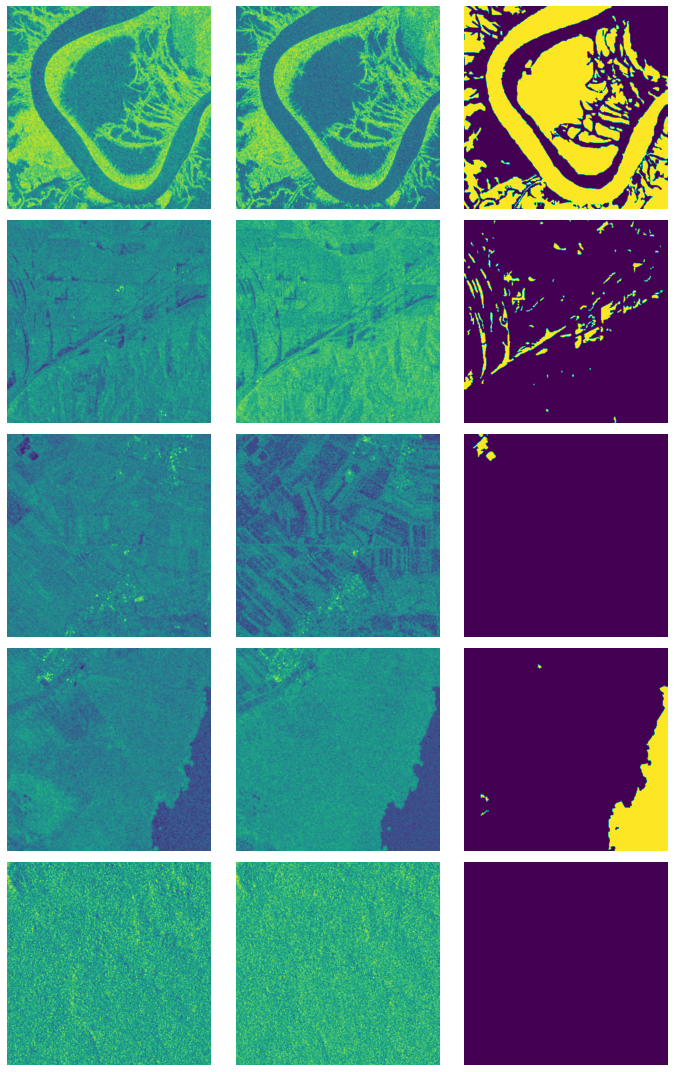

In [6]:
import matplotlib.pyplot as plt 

batch = next(iter(ds.train_dataloader()))
imgs, masks = batch['image'], batch['mask']

fig = plt.figure(figsize=(10,len(imgs)*3))
for ix, (img, mask) in enumerate(zip(imgs, masks)):
	ax = plt.subplot(len(imgs),3,3*ix + 1)
	ax.imshow(img[...,0])
	ax.axis('off')
	ax = plt.subplot(len(imgs),3,3*ix +2)
	ax.imshow(img[...,1])
	ax.axis('off')
	ax = plt.subplot(len(imgs),3,3*ix +3)
	ax.imshow(mask == 1)
	ax.axis('off')
plt.tight_layout()
plt.show()

Data augmentation

In [7]:
import albumentations as A 

trans = A.Compose([
	A.RandomRotate90(),
	A.HorizontalFlip(),
	A.VerticalFlip(),
])

In [8]:
ds = STACOverflow(batch_size=5, train_trans=trans)

ds.setup()

/tmp/ipykernel_689665/1849456672.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['image'] = metadata_filtered.chip_id.apply(
/tmp/ipykernel_689665/1849456672.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['prefix'] = metadata_filtered.chip_id.apply(
/tmp/ipykernel_689665/1849456672.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

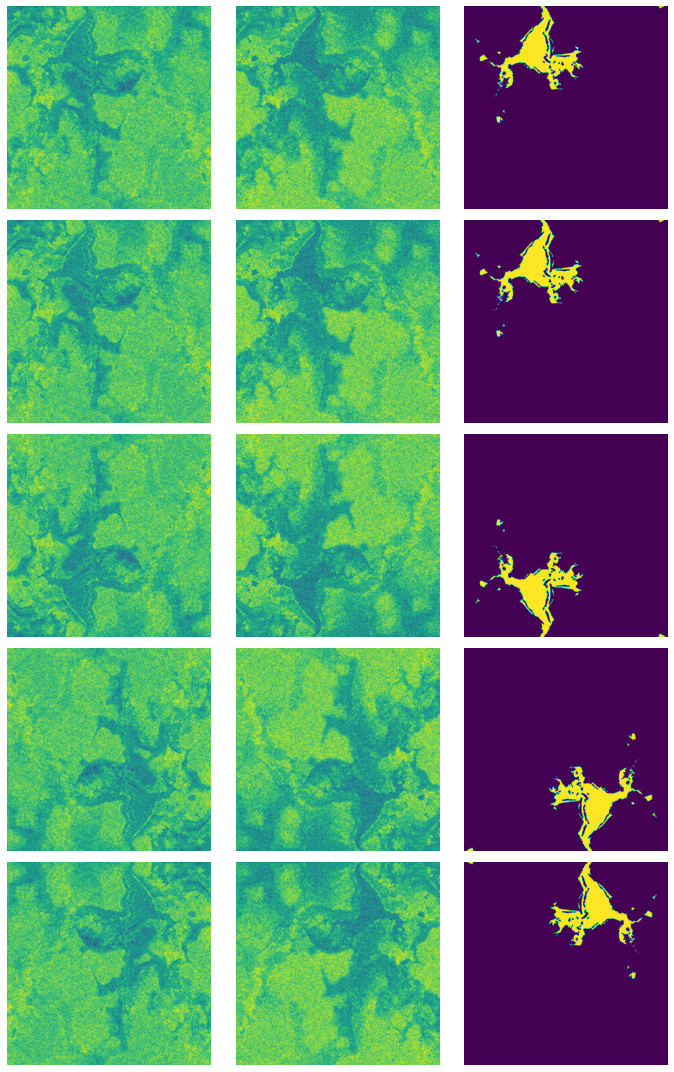

In [9]:
import random

s = random.randint(0, len(ds.train_ds)-1)

rounds = 5
fig = plt.figure(figsize=(10,rounds*3))
for ix in range(rounds):
	sample = ds.train_ds[s]
	img, mask = sample['image'], sample['mask']
	ax = plt.subplot(rounds,3,3*ix + 1)
	ax.imshow(img[...,0])
	ax.axis('off')
	ax = plt.subplot(rounds,3,3*ix +2)
	ax.imshow(img[...,1])
	ax.axis('off')
	ax = plt.subplot(rounds,3,3*ix +3)
	ax.imshow(mask == 1)
	ax.axis('off')
plt.tight_layout()
plt.show()

## The Model

In [20]:
import segmentation_models_pytorch as smp
from einops import rearrange
import torch

class Model(torch.nn.Module):

	def __init__(self, in_chans, encoder='resnet18', pretrained=None):
		super().__init__()
		self.model = smp.Unet(
			encoder_name=encoder,
			encoder_weights=pretrained,
			in_channels=in_chans,
			classes=1,
		)

	def forward(self, x):
		x = rearrange(x, 'b h w c -> b c h w')
		# normalize
		# x = 10.**(x / 10.)  # undo db
		# x = torch.clip(x, 0, 1)  # 0-1
		x = torch.clip(x, -30, 0)*(-8.4) / 255. # ??
		y = self.model(x)
		return y.squeeze(1) # remove channels dim

model = Model(in_chans=2)

In [21]:
from pytorch_eo.tasks.segmentation import ImageSegmentation

task = ImageSegmentation(model)

out = task(imgs)

out.shape, out.dtype

(torch.Size([5, 512, 512]), torch.float32)

## Training

In [22]:
def iou(pr, gt, th=0.5, eps=1e-7):
        mask = gt.ne(255) # ignore value 255 in mask
        gt = gt.masked_select(mask)
        pr = pr.masked_select(mask)
        pr = torch.sigmoid(pr) > th
        gt = gt > th # remove channels dim
        intersection = torch.sum(gt & pr)
        union = torch.sum(gt | pr)
        return intersection / (union + eps)

In [23]:
hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 3e-4
    }
}

loss_fn = smp.losses.SoftBCEWithLogitsLoss(ignore_index=255) # ignore value 255 in mask

Overfit batches

In [24]:
import pytorch_lightning as pl 

ds = STACOverflow(batch_size=10)

model = Model(in_chans=2)
task = ImageSegmentation(model, hparams=hparams, loss_fn=loss_fn, metrics={'iou': iou})

trainer = pl.Trainer(
    logger=None,
    max_epochs=50,
    overfit_batches=1,
    checkpoint_callback=False,
    gpus=1,
    precision=16
)

#trainer.fit(task, ds)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Baseline

In [26]:
from pytorch_lightning.callbacks import ModelCheckpoint

pl.seed_everything(42, workers=True)

ds = STACOverflow(batch_size=32, train_trans=trans)

model = Model(in_chans=2, encoder='resnet18', pretrained='imagenet')

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 3e-4
    },
	'scheduler': 'MultiStepLR',
	'scheduler_params': {
		'milestones': [10, 20],
		# 'verbose': True
	}
}

task = ImageSegmentation(model, hparams=hparams, loss_fn=loss_fn, metrics={'iou': iou})

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    precision=16,
	callbacks=[
		ModelCheckpoint(
			dirpath='./',
			filename=f"unet-baseline-{{val_iou:.4f}}",
			save_top_k=1,
			monitor='val_iou',
			mode='max'
		)
	],
	deterministic=True,
)

trainer.fit(task, ds)

Global seed set to 42
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/tmp/ipykernel_689665/1849456672.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['image'] = metadata_filtered.chip_id.apply(
/tmp/ipykernel_689665/1849456672.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Validation sanity check: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a 

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Second place model from https://github.com/max-lutz/floodwater_competition/blob/main/src/models/train_model.ipynb

In [16]:
import torch.nn as nn 

def conv2d_block(in_c, out_c):
	return nn.Sequential(
		nn.Conv2d(in_c, out_c, 3, padding=1),
		nn.BatchNorm2d(out_c),
		nn.ReLU(),
		nn.Conv2d(out_c, out_c, 3, padding=1),
		nn.BatchNorm2d(out_c),
		nn.ReLU(),
	)

def encoder_block(in_c, out_c, p=0.):
	return nn.Sequential(
		nn.MaxPool2d(2),
		nn.Dropout(p),
		conv2d_block(in_c, out_c)
	)

class DecoderBlock(nn.Module):
	def __init__(self, in_c, out_c, p=0.):
		super().__init__()
		self.convt = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
		self.drop = nn.Dropout(p)
		self.conv_block = conv2d_block(in_c, out_c)

	def forward(self, x1, x2):
		x1 = self.convt(x1)
		x = torch.cat([x1, x2], axis=1)
		x = self.drop(x)
		return self.conv_block(x)


class UNet(nn.Module):
	def __init__(self, in_chans=2, f=[16, 32, 64, 128, 256], p=0.):
		super().__init__()
		self.in_conv = conv2d_block(in_chans, f[0])
		self.encoder = nn.ModuleList([
			encoder_block(f[ix], f[ix+1], 0.5*p if ix == 0 else p) for ix in range(len(f)-1)
		])
		self.decoder = nn.ModuleList([
			DecoderBlock(f[ix], f[ix-1], p) for ix in reversed(range(1, len(f)))
		])
		self.out_conv = nn.Conv2d(f[0], 1, 1)

	def forward(self, x):
		x = rearrange(x, 'b h w c -> b c h w')
		# normalize
		# clip values out of -30;0 range and map them to 0;255 range 
		x = torch.clip(x, -30, 0)*(-8.4) / 255. # ??
		x = self.in_conv(x)
		xs = []
		for encoder_layer in self.encoder:
			xs.append(x)
			x = encoder_layer(x)
		for _x, decoder_layer in zip(reversed(xs), self.decoder):
			x = decoder_layer(x, _x)
		return self.out_conv(x).squeeze(1) # remove channels dim

In [17]:
unet = UNet()

out = unet(imgs)

out.shape

torch.Size([5, 512, 512])

In [18]:
def dice_loss_square(pr, gt, th = 0.5, smooth=1):
  mask = gt.ne(255) # ignore value 255 in mask
  gt = gt.masked_select(mask)
  pr = pr.masked_select(mask)
  pr = torch.sigmoid(pr) 
  gt = gt 
  pr = pr.view(-1)
  gt = gt.view(-1)
  intersection = torch.sum(gt * pr)
  return 1-((2. * intersection + smooth) / (torch.sum(pr**2) + torch.sum(gt**2) + smooth))

In [19]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pl.seed_everything(42, workers=True)

ds = STACOverflow(batch_size=8, train_trans=trans)

model = UNet(p=0.05)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-3
    },
	'scheduler': 'MultiStepLR',
	'scheduler_params': {
		'milestones': [20, 80],
		'verbose': True
	}
}

task = ImageSegmentation(model, hparams=hparams, loss_fn=dice_loss_square, metrics={'iou': iou})

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    precision=16,
	callbacks=[
		ModelCheckpoint(
			dirpath='./',
			filename=f"unet-{{val_iou:.4f}}",
			save_top_k=1,
			monitor='val_iou',
			mode='max'
		),
		EarlyStopping(monitor="val_loss", patience=10, verbose=True)
	],
	deterministic=True,
)

trainer.fit(task, ds)

Global seed set to 42
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/tmp/ipykernel_689665/1849456672.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['image'] = metadata_filtered.chip_id.apply(
/tmp/ipykernel_689665/1849456672.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.343


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.283


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.245


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.191


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.181


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.147


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.146


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.140


Adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.131


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.128


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.127


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.126


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.124


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.121


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.120


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.111


Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.111. Signaling Trainer to stop.
